In [5]:
import pandas as pd
from matplotlib import pyplot as plt


df_EL = pd.read_csv('./output/EL/results.csv')
df_EP = pd.read_csv('./output/EP/results.csv')
df_L = pd.read_csv('./output/L/results.csv')


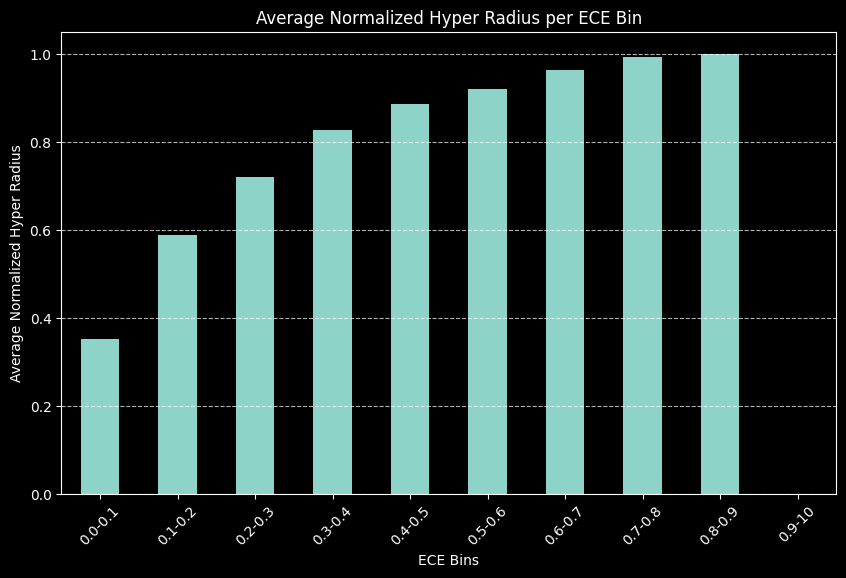

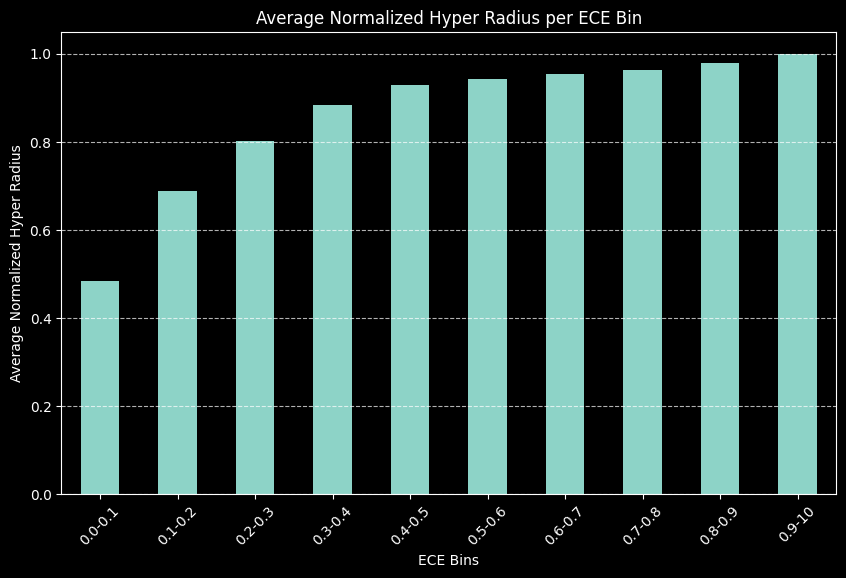

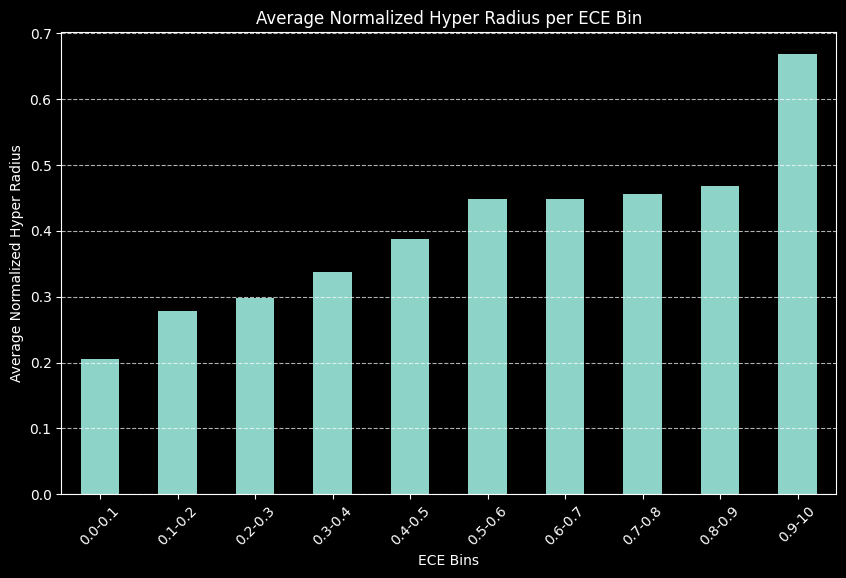

In [6]:

# Assuming ECE bins are defined by confidence values
ece_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 10]  # Bins from 0.0 to 1.0 with step 0.1
df_EL['ece_bins'] = pd.cut(df_EL['confidence'], bins=ece_bins, labels=[f'{ece_bins[i]}-{ece_bins[i+1]}' for i in range(len(ece_bins)-1)])

# Plot the histogram
plt.figure(figsize=(10, 6))
df_EL.groupby('ece_bins')['norm_radius'].mean().plot(kind='bar')

plt.xlabel('ECE Bins')
plt.ylabel('Average Normalized Hyper Radius')
plt.title('Average Normalized Hyper Radius per ECE Bin')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()




df_EP['ece_bins'] = pd.cut(df_EP['confidence'], bins=ece_bins, labels=[f'{ece_bins[i]}-{ece_bins[i+1]}' for i in range(len(ece_bins)-1)])

# Plot the histogram
plt.figure(figsize=(10, 6))
df_EP.groupby('ece_bins')['norm_radius'].mean().plot(kind='bar')

plt.xlabel('ECE Bins')
plt.ylabel('Average Normalized Hyper Radius')
plt.title('Average Normalized Hyper Radius per ECE Bin')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()




df_L['ece_bins'] = pd.cut(df_L['confidence'], bins=ece_bins, labels=[f'{ece_bins[i]}-{ece_bins[i+1]}' for i in range(len(ece_bins)-1)])

# Plot the histogram
plt.figure(figsize=(10, 6))
df_L.groupby('ece_bins')['norm_radius'].mean().plot(kind='bar')

plt.xlabel('ECE Bins')
plt.ylabel('Average Normalized Hyper Radius')
plt.title('Average Normalized Hyper Radius per ECE Bin')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
